<a href="https://colab.research.google.com/github/Mohinee29/Quora-Question-Pair-Similarity/blob/main/4_ML_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import sqlite3
from sqlalchemy import create_engine # database connection
import csv
import os
warnings.filterwarnings("ignore")
import datetime as dt
import numpy as np
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold 
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier




from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDClassifier
import six
import sys
sys.modules['sklearn.externals.six'] = six

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, auc, roc_curve

<h1>4. Machine Learning Models </h1>

<h2> 4.1 Reading data from file and storing into sql table </h2>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
df = pd.read_csv("/content/drive/MyDrive/Quora/final_features.csv")
df.head()

,Unnamed: 0,id,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,...,290_y,291_y,292_y,293_y,294_y,295_y,296_y,297_y,298_y,299_y
0,0,398782,1,0.874989,0.874989,0.999980,0.999980,0.923070,0.923070,1.0,...,-33.521917,4.900120,17.347702,11.634150,-5.349538,-4.069301,3.427811,-2.312354,-2.384895,7.259330
1,1,115086,0,0.666644,0.499988,0.714276,0.624992,0.583328,0.466664,1.0,...,-21.094213,4.433884,-9.766198,-5.465565,9.470171,10.817784,1.042753,-12.991802,2.166817,4.231539
2,2,327711,0,0.000000,0.000000,0.428565,0.272725,0.149999,0.115384,0.0,...,8.499174,-15.966543,3.993850,-7.849429,-5.492049,-7.836266,-0.272645,46.178656,13.207780,21.047092
3,3,367788,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,-1.578354,-6.124876,-5.524728,-2.407836,36.537639,5.944407,-1.175200,38.982331,20.501046,2.190571
4,4,151235,0,0.749981,0.599988,0.000000,0.000000,0.599988,0.333330,1.0,...,-12.053610,0.963612,16.356464,-11.359396,0.024958,7.979280,-9.142534,6.566577,-3.385568,18.179580


In [11]:
# remove the first row 
df.drop(df.index[0], inplace=True)
y_true = df['is_duplicate']
df.drop(['Unnamed: 0', 'id','is_duplicate'], axis=1, inplace=True)

In [13]:
df.head()

,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,...,290_y,291_y,292_y,293_y,294_y,295_y,296_y,297_y,298_y,299_y
2,0.000000,0.000000,0.428565,0.272725,0.149999,0.115384,0.0,0.0,6.0,23.0,...,8.499174,-15.966543,3.993850,-7.849429,-5.492049,-7.836266,-0.272645,46.178656,13.207780,21.047092
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,17.0,21.5,...,-1.578354,-6.124876,-5.524728,-2.407836,36.537639,5.944407,-1.175200,38.982331,20.501046,2.190571
4,0.749981,0.599988,0.000000,0.000000,0.599988,0.333330,1.0,0.0,4.0,7.0,...,-12.053610,0.963612,16.356464,-11.359396,0.024958,7.979280,-9.142534,6.566577,-3.385568,18.179580
5,0.499988,0.249997,0.000000,0.000000,0.399992,0.068965,0.0,0.0,24.0,17.0,...,-8.718690,-5.008443,-9.781965,-3.519412,3.827268,21.402206,-5.679073,1.139505,6.902079,-5.674351
6,0.428565,0.157894,0.599988,0.157894,0.399997,0.139535,0.0,0.0,28.0,29.0,...,-59.938133,13.030580,-9.055627,-15.945319,30.795898,11.925300,-12.690169,-20.733054,16.431554,14.252697


<h2> 4.2 Converting strings to numerics </h2>

In [14]:
# after we read from sql table each entry was read it as a string
# we convert all the features into numaric before we apply any model
cols = list(df.columns)
for i in cols:
    df[i] = df[i].apply(pd.to_numeric)
    print(i)

cwc_min
cwc_max
csc_min
csc_max
ctc_min
ctc_max
last_word_eq
first_word_eq
abs_len_diff
mean_len
token_set_ratio
token_sort_ratio
fuzz_ratio
fuzz_partial_ratio
longest_substr_ratio
freq_qid1
freq_qid2
q1len
q2len
q1_n_words
q2_n_words
word_Common
word_Total
word_share
freq_q1+q2
freq_q1-q2
0_x
1_x
2_x
3_x
4_x
5_x
6_x
7_x
8_x
9_x
10_x
11_x
12_x
13_x
14_x
15_x
16_x
17_x
18_x
19_x
20_x
21_x
22_x
23_x
24_x
25_x
26_x
27_x
28_x
29_x
30_x
31_x
32_x
33_x
34_x
35_x
36_x
37_x
38_x
39_x
40_x
41_x
42_x
43_x
44_x
45_x
46_x
47_x
48_x
49_x
50_x
51_x
52_x
53_x
54_x
55_x
56_x
57_x
58_x
59_x
60_x
61_x
62_x
63_x
64_x
65_x
66_x
67_x
68_x
69_x
70_x
71_x
72_x
73_x
74_x
75_x
76_x
77_x
78_x
79_x
80_x
81_x
82_x
83_x
84_x
85_x
86_x
87_x
88_x
89_x
90_x
91_x
92_x
93_x
94_x
95_x
96_x
97_x
98_x
99_x
100_x
101_x
102_x
103_x
104_x
105_x
106_x
107_x
108_x
109_x
110_x
111_x
112_x
113_x
114_x
115_x
116_x
117_x
118_x
119_x
120_x
121_x
122_x
123_x
124_x
125_x
126_x
127_x
128_x
129_x
130_x
131_x
132_x
133_x
134_x
135_x
136

In [15]:
# https://stackoverflow.com/questions/7368789/convert-all-strings-in-a-list-to-int
y_true = list(map(int, y_true.values))

<h2> 4.3 Random train test split( 70:30) </h2>

In [16]:
X_train,X_test, y_train, y_test = train_test_split(df, y_true, stratify=y_true, test_size=0.3)

In [17]:
print("Number of data points in train data :",X_train.shape)
print("Number of data points in test data :",X_test.shape)

Number of data points in train data : (20998, 626)
Number of data points in test data : (9000, 626)


In [18]:
print("-"*10, "Distribution of output variable in train data", "-"*10)
train_distr = Counter(y_train)
train_len = len(y_train)
print("Class 0: ",int(train_distr[0])/train_len,"Class 1: ", int(train_distr[1])/train_len)
print("-"*10, "Distribution of output variable in train data", "-"*10)
test_distr = Counter(y_test)
test_len = len(y_test)
print("Class 0: ",int(test_distr[1])/test_len, "Class 1: ",int(test_distr[1])/test_len)

---------- Distribution of output variable in train data ----------
Class 0:  0.6337746452043052 Class 1:  0.36622535479569485
---------- Distribution of output variable in train data ----------
Class 0:  0.3662222222222222 Class 1:  0.3662222222222222


In [19]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    plt.figure(figsize=(20,4))
    
    labels = [1,2]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

<h2> 4.4 Building a random model (Finding worst-case log-loss) </h2>

Log loss on Test Data using Random Model 0.8889644554871705


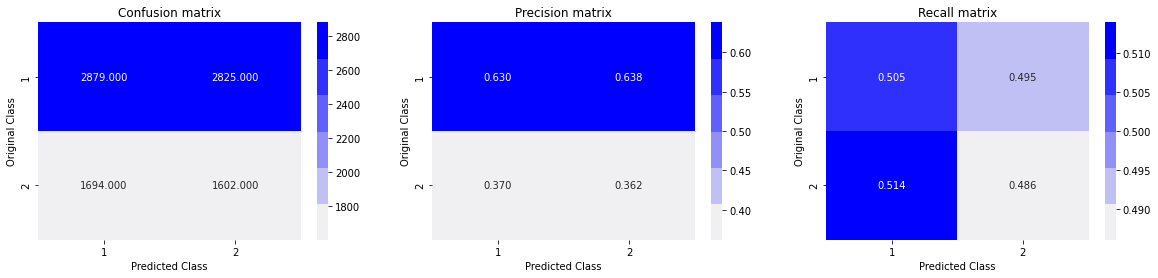

In [20]:
# we need to generate 9 numbers and the sum of numbers should be 1
# one solution is to genarate 9 numbers and divide each of the numbers by their sum
# ref: https://stackoverflow.com/a/18662466/4084039
# we create a output array that has exactly same size as the CV data
predicted_y = np.zeros((test_len,2))
for i in range(test_len):
    rand_probs = np.random.rand(1,2)
    predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model",log_loss(y_test, predicted_y, eps=1e-15))

predicted_y =np.argmax(predicted_y, axis=1)
plot_confusion_matrix(y_test, predicted_y)

<h2> 4.4 Logistic Regression with hyperparameter tuning </h2>

For values of alpha =  1e-05 The log loss is: 0.5064574088904854
For values of alpha =  0.0001 The log loss is: 0.5054828748750876
For values of alpha =  0.001 The log loss is: 0.4911929462339816
For values of alpha =  0.01 The log loss is: 0.48020182926872024
For values of alpha =  0.1 The log loss is: 0.502627503353248
For values of alpha =  1 The log loss is: 0.5169770039941226
For values of alpha =  10 The log loss is: 0.5444490097504304


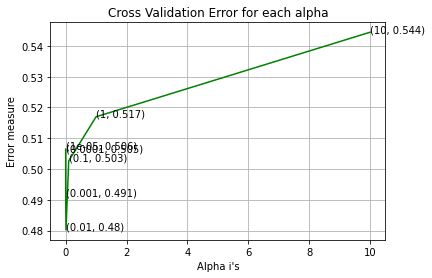

For values of best alpha =  0.01 The train log loss is: 0.4599845051226137
For values of best alpha =  0.01 The test log loss is: 0.48020182926872024
Total number of data points : 9000


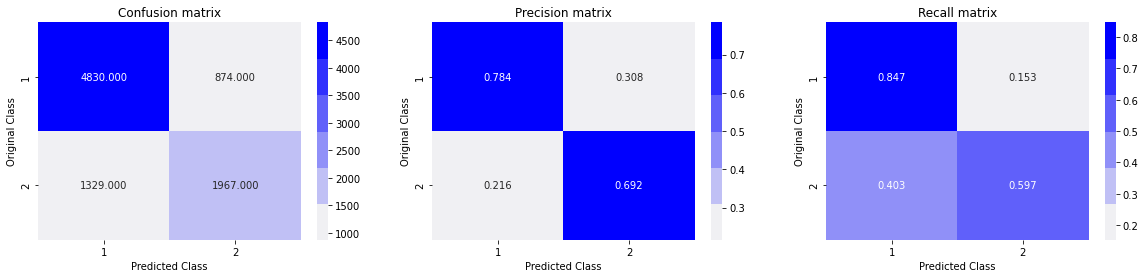

In [21]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------


log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

<h2> 4.5 Linear SVM with hyperparameter tuning </h2>

For values of alpha =  1e-05 The log loss is: 0.5024280173625
For values of alpha =  0.0001 The log loss is: 0.5073000321897249
For values of alpha =  0.001 The log loss is: 0.5270270062208197
For values of alpha =  0.01 The log loss is: 0.5376362257181844
For values of alpha =  0.1 The log loss is: 0.5502697700833438
For values of alpha =  1 The log loss is: 0.6380273123810982
For values of alpha =  10 The log loss is: 0.6503175858098665


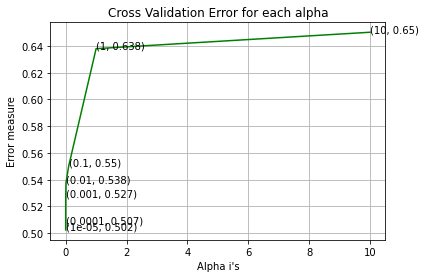

For values of best alpha =  1e-05 The train log loss is: 0.4773056867721503
For values of best alpha =  1e-05 The test log loss is: 0.5024280173625
Total number of data points : 9000


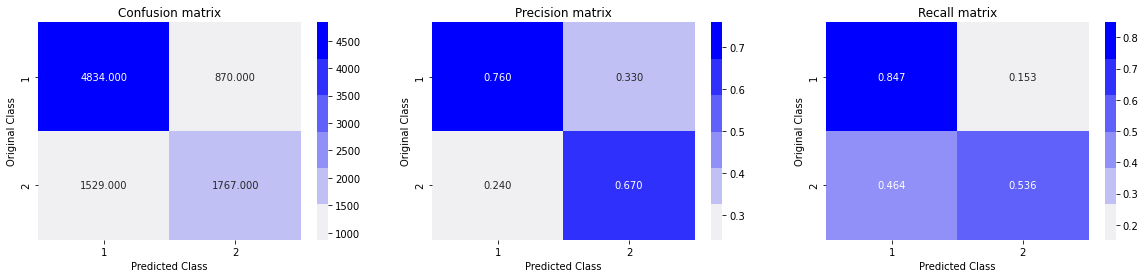

In [22]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------


log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l1', loss='hinge', random_state=42)
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l1', loss='hinge', random_state=42)
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

<h2> 4.6 XGBoost </h2>

In [23]:
import xgboost as xgb
params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'logloss'
params['eta'] = 0.02
params['max_depth'] = 4

d_train = xgb.DMatrix(X_train, label=y_train)
d_test = xgb.DMatrix(X_test, label=y_test)

watchlist = [(d_train, 'train'), (d_test, 'valid')]

bst = xgb.train(params, d_train, 400, watchlist, early_stopping_rounds=20, verbose_eval=10)

xgdmat = xgb.DMatrix(X_train,y_train)
predict_y = bst.predict(d_test)
print("The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

[0]	train-logloss:0.685993	valid-logloss:0.68627
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 20 rounds.
[10]	train-logloss:0.627209	valid-logloss:0.629152
[20]	train-logloss:0.584633	valid-logloss:0.58789
[30]	train-logloss:0.552726	valid-logloss:0.557279
[40]	train-logloss:0.528209	valid-logloss:0.53389
[50]	train-logloss:0.508825	valid-logloss:0.515465
[60]	train-logloss:0.493468	valid-logloss:0.501111
[70]	train-logloss:0.480651	valid-logloss:0.489168
[80]	train-logloss:0.470335	valid-logloss:0.479802
[90]	train-logloss:0.461675	valid-logloss:0.472085
[100]	train-logloss:0.454421	valid-logloss:0.465741
[110]	train-logloss:0.448185	valid-logloss:0.460535
[120]	train-logloss:0.442559	valid-logloss:0.455887
[130]	train-logloss:0.437636	valid-logloss:0.452059
[140]	train-logloss:0.433034	valid-logloss:0.448425
[150]	train-logloss:0.428988	valid-logloss:0.445285
[160]	train-logloss:0.425112	va

Total number of data points : 9000


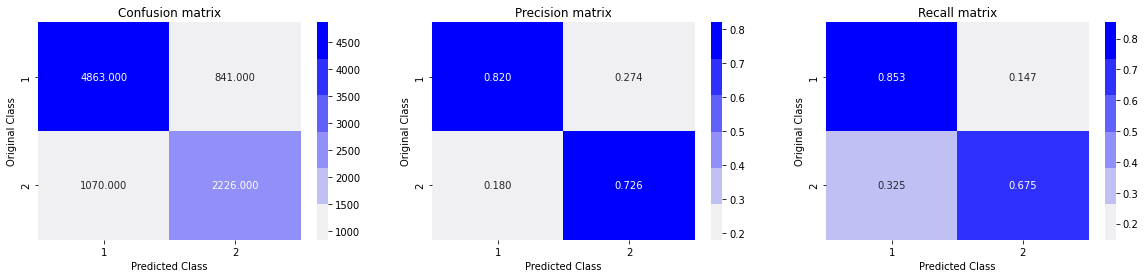

In [24]:
predicted_y =np.array(predict_y>0.5,dtype=int)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)